In [1]:
import os

def import_from_directory(directory, module_name):
    current_dir = os.getcwd()
    os.chdir(directory)
    module = __import__(module_name)
    os.chdir(current_dir)
    return module

test_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'test_base')
model_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'model_base')

2024-05-14 08:45:52.275103: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 08:45:52.311523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 08:45:52.311562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 08:45:52.312457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 08:45:52.318617: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
model_base.set_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/notebooks/'
os.chdir(desired_directory)

In [3]:
import pandas as pd

In [4]:
df0 = pd.read_csv('Data/df.csv').rename(columns={'Unnamed: 0': 'indexid'})
df = pd.read_csv('Data/tabledata_all.csv')
dfx = df.merge(df0[['AlignmentID', 'INCHIKEY','MSMSspectrum', 'indexid']], on=['AlignmentID', 'INCHIKEY','MSMSspectrum'], how='left')
dfx = dfx.drop_duplicates(subset=['datasetID','AlignmentID', 'INCHIKEY','MSMSspectrum']).reset_index(drop=True).\
sort_values('indexid', ascending=True)

In [5]:
df_pos = dfx[dfx['Adducttype'].str.contains('\]\+') | dfx['Adducttype'].str.contains('\]2\+')].reset_index(drop=True)
df_pos2 = model_base.cal_df_sel_column(df_pos)
df_pos_wide = model_base.cal_wide_df(df_pos2)

".ms" fileの作成

In [6]:
output_file_path = 'Data/test_data/pos/ms2_spectrum_ms_pos'
test_base.make_ms_file(df_pos, output_file_path)

In [ ]:
zip_filename = 'Data/test_data/pos/ms2_spectrum_ms_pos.zip'
test_base.make_zipfile(output_file_path, zip_filename)

canopusでの予測結果の読み込み

In [6]:
canopus_result_path = 'Data/test_data/pos/canopus_compound_summary_pos.tsv'
select_ont_path = 'Data/test_data/pos/subclass_ont_select_pos.csv'
ytest_path = 'Data/model_data/pos/df_pos_ytest.csv'
model_test_result = 'Data/model_data/pos/df_pos_subclass_pred_each.csv'
df_model_canopus = test_base.read_canopus_output(canopus_result_path, select_ont_path, ytest_path, model_test_result, df_pos_wide, df_pos2)

In [7]:
subclasslist = ['Monoradylglycerols', 'Ceramides', 'Diradylglycerols',
 'Triradylglycerols', 'Phosphosphingolipids', 'Glycosphingolipids',
 'Glycerophosphoethanolamines', 'Glycerophosphoglycerols']

df_model_canopus = df_model_canopus[df_model_canopus['subclass'].isin(subclasslist)]

In [8]:
df_pos_cano_class_summary = test_base.df_comp_pred_result(df_model_canopus)

In [60]:
excel_file_path = 'Data/model_data/pos/classification_reports_pos.xlsx'
test_base.make_classification_reports(df_model_canopus.astype(str), excel_file_path)

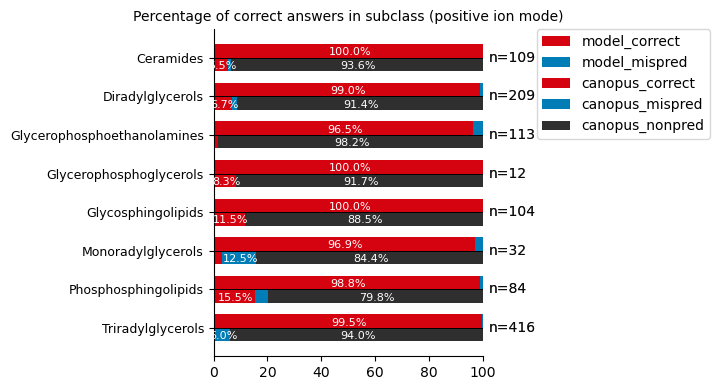

In [61]:
save_fig_path = 'Data/test_data/pos/canopus_compound_summary_pos.svg'
test_base.plot_canopus_result(df_pos_cano_class_summary, save_fig_path, title='Percentage of correct answers in subclass (positive ion mode)')